In [1]:
import numpy as np


from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

# imports for run time
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# used for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

In [3]:
# select hardware to run on (can use local backend if no access to hardware)
# To run on hardware, select the backend with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
# backend.name


# local backend
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
fake_brisbane = FakeBrisbane()

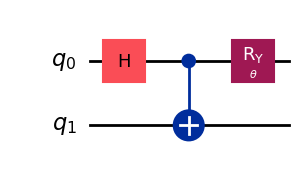

In [4]:
# this is the parameter that will change over time
theta = Parameter("$\\theta$")

# create the circuit to be iterated over with different parameter values
chsh_circuit = QuantumCircuit(2)
# H-gate on qubit 0
chsh_circuit.h(0)
# c-not gate on qubit 0 and 1
chsh_circuit.cx(0, 1)
# something related to the parameter???
chsh_circuit.ry(theta, 0)

# draw circuit
chsh_circuit.draw(output="mpl", idle_wires=False, style="iqp")

In [5]:
# create n phase values betwwon 0 and 2pi
n = 21
phases = np.linspace(0 , 2 * np.pi, n)

# PUB (primitive unified blocks) require list input of parameters
phases_list = [[ph] for ph in phases]


In [6]:
# once our phases and qubits are defined we need observables for the expirement

# <x> notation means the estimated/average value of x
# CHSH = <AB> - <Ab> + <aB> + <ab> --> <ZZ> - <ZX> + <XZ> + <XX>
chsh_obs1 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", -1), ("XZ", 1), ("XX", 1)])
# CHSH = <AB> + <Ab> - <aB> + <ab> --> <ZZ> + <ZX> - <XZ> + <XX>
chsh_obs2 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", 1), ("XZ", -1), ("XX", 1)])


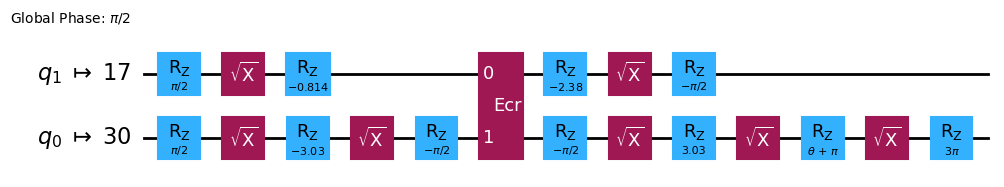

In [7]:
# now the circuit created must be optimized for specific hardware
# referred to as ISA (intrustiion set architecture)

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# create passmanager
pm = generate_preset_pass_manager(backend= fake_brisbane, optimization_level=3)

# run circuit and draw it
chsh_isa_circuit = pm.run(chsh_circuit)
chsh_isa_circuit.draw(output="mpl", idle_wires=False, style="iqp")

In [11]:
# must also change the observables so that they are tailored to the backend
isa_observable1 = chsh_obs1.apply_layout(layout=chsh_isa_circuit.layout)
isa_observable2 = chsh_obs2.apply_layout(layout=chsh_isa_circuit.layout)

In [13]:
from qiskit.primitives import StatevectorEstimator

estimator = Estimator(backend=fake_brisbane)


# primitive unified blocks are used to iterate over different parameters
pub = (
    chsh_isa_circuit,  # ISA circuit
    [[isa_observable1], [isa_observable2]],  # ISA Observables
    phases_list,  # Parameter values
)

job_result = estimator.run(pubs=[pub]).result()

/var/folders/z5/vj7wxths23768hdrgtg7ck6r0000gn/T/ipykernel_2037/3380035491.py:3: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = Estimator(backend=fake_brisbane)


In [14]:
# get esitmate values from job result
chsh1_est = job_result[0].data.evs[0]
chsh2_est = job_result[0].data.evs[1]

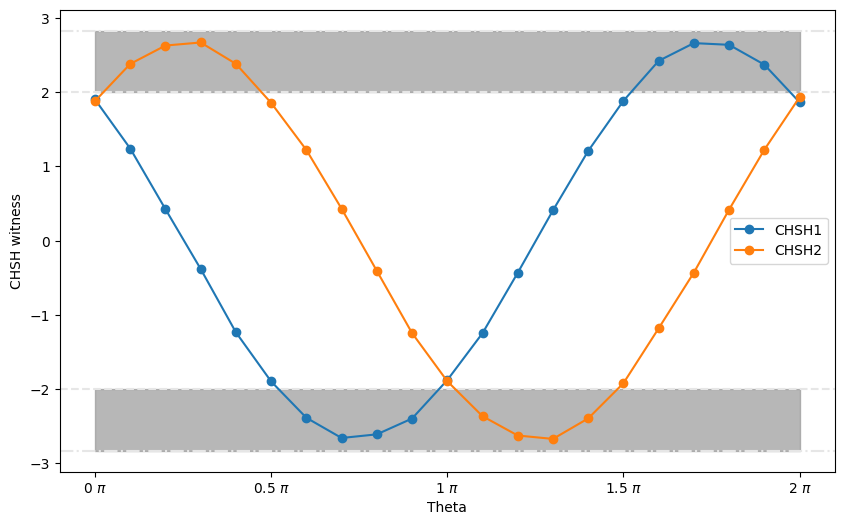

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, chsh1_est, "o-", label="CHSH1", zorder=3)
ax.plot(phases / np.pi, chsh2_est, "o-", label="CHSH2", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")

# shadows the region outside of classical
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))

# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()

`within the average results we can see in certain phases that our observations are outside the realm of classical physics`

In [ ]:
# notes
# - understand what ry is in line 11 of section 3
# - understand what SparsePauliOperator is?
# - understand circuit that is produced in section 3 and section 6